# CoLeaf CNN

## Imports and configurations

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from network import Net
import torch.optim as optim
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from tqdm.notebook import tqdm
from dataset import CoLeafDataset
import dataclasses

from trainer import CoLeafTrainer

In [2]:
IMG_SIZE        = 224
BATCH_SIZE      = 32
WORKERS         = 4
EPOCHS          = 50
LR              = 0.001
PATIENCE        = 10
DELTA           = 0
MODEL_VERSION   = "v1"
DATASET_PATH    = "./CoLeaf DATASET"
OUTPUT_PATH     = "./output"
MODEL_PATH      = f"./output/model_{MODEL_VERSION}.pth"

In [3]:
os.makedirs(OUTPUT_PATH, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Dataset and dataloaders

### Load dataset

In [4]:
p_bar = tqdm(range(4), desc='Loading datasets...')
dataset: CoLeafDataset = torch.load(os.path.join(OUTPUT_PATH, "datasets/dataset.pt"), weights_only=False)
p_bar.update(1)
train_dataset = torch.load(os.path.join(OUTPUT_PATH, 'datasets/train_augmented_dataset.pt'), weights_only=False)
p_bar.update(1)
val_dataset = torch.load(os.path.join(OUTPUT_PATH, 'datasets/val_dataset.pt'), weights_only=False)
p_bar.update(1)
test_dataset = torch.load(os.path.join(OUTPUT_PATH, 'datasets/test_dataset.pt'), weights_only=False)
p_bar.update(1)

Loading datasets...:   0%|          | 0/4 [00:00<?, ?it/s]

True

In [5]:
classes = dataset.classes
class_labels = dataset.labels
print(classes)

['boron-B', 'calcium-Ca', 'healthy', 'iron-Fe', 'magnesium-Mg', 'manganese-Mn', 'more-deficiencies', 'nitrogen-N', 'phosphorus-P', 'potasium-K']


### Create dataloaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True)
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

## Training

### Train and save results

In [7]:
net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

In [8]:
trainer = CoLeafTrainer(
    model=net,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
    patience=PATIENCE,
    delta=DELTA
)

trainer.train()
trainer.save_model(MODEL_PATH)
train_metrics = pd.DataFrame([dataclasses.asdict(metric) for metric in trainer.metrics])
train_metrics.to_csv(os.path.join(OUTPUT_PATH, f"metrics/train_metrics_{MODEL_VERSION}.csv"), header=True, sep=';')

AttributeError: 'CoLeafDataset' object has no attribute 'dataset'

### Visualization


#### Load data

In [ ]:
train_metrics = pd.read_csv(os.path.join(OUTPUT_PATH, f"metrics/train_metrics_{MODEL_VERSION}.csv"), sep=';')

### Model loss and accuracy

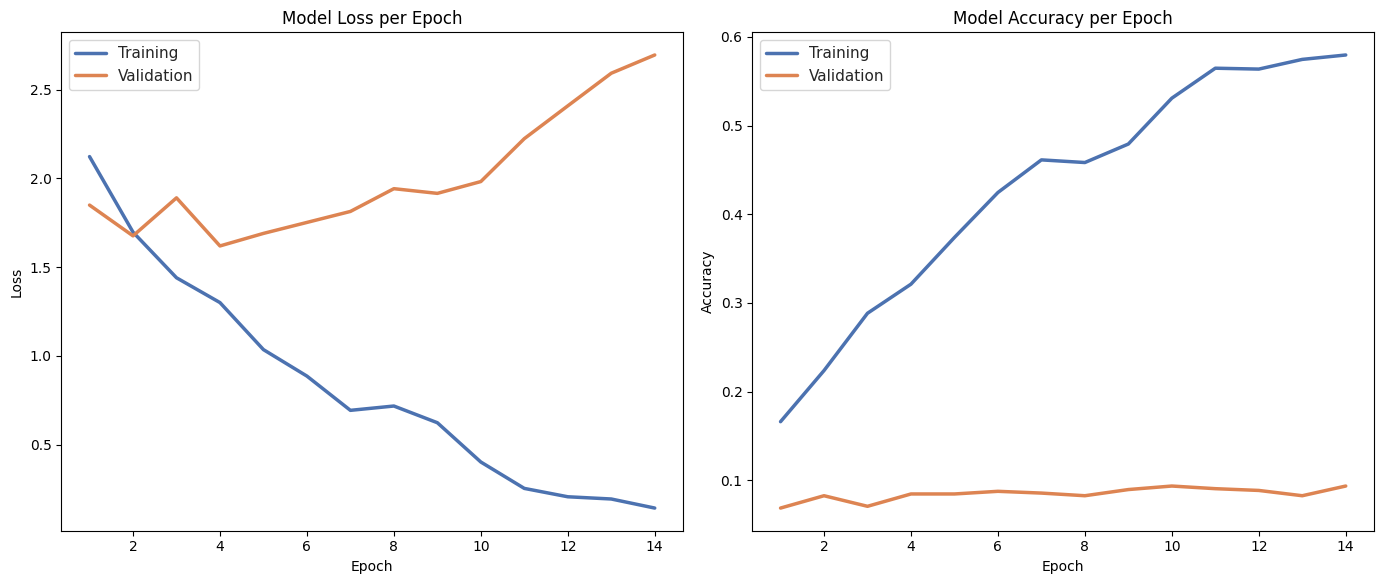

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

df_loss_wide = train_metrics.loc[:, ['train_loss', 'val_loss']]
df_loss_wide.columns = ['Training', 'Validation']
df_loss_wide['Epoch'] = df_loss_wide.index + 1

df_loss= pd.melt(
    df_loss_wide,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Type',
    value_name='Loss'
)

sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Type', linewidth=2.5, ax=axes[0])
axes[0].set_title('Model Loss per Epoch')
axes[0].legend(title='')

df_acc_wide = train_metrics.loc[:, ['train_acc', 'val_acc']]
df_acc_wide.columns = ['Training', 'Validation']
df_acc_wide['Epoch'] = df_acc_wide.index + 1
df_acc = pd.melt(
    df_acc_wide,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Type',
    value_name='Accuracy'
)

sns.lineplot(data=df_acc, x='Epoch', y='Accuracy', hue='Type', linewidth=2.5, ax=axes[1])
axes[1].set_title('Model Accuracy per Epoch')
axes[1].legend(title='')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/model_performance_{MODEL_VERSION}.png"))
plt.show()

## Testing

### Test and save results

In [11]:
net = Net().to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [12]:
net.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for data in tqdm(test_loader, desc="Evaluating..."):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        probs = torch.softmax(outputs, dim=1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
all_probs  = np.array(all_probs)
all_labels = np.array(all_labels)
y_true = label_binarize(all_labels, classes=list(range(len(classes))))    
df_report = pd.DataFrame(report).transpose()
df_report['class'] = df_report.index
df_report.reset_index(drop=True, inplace=True)

df_report.to_csv(os.path.join(OUTPUT_PATH, f"metrics/classification_report_{MODEL_VERSION}.csv"), sep=';')
np.save(os.path.join(OUTPUT_PATH, f"metrics/confusion_matrix_{MODEL_VERSION}.npy"), cm)
np.save(os.path.join(OUTPUT_PATH, f"metrics/all_probs_{MODEL_VERSION}.npy"), all_probs)
np.save(os.path.join(OUTPUT_PATH, f"metrics/y_true{MODEL_VERSION}.npy"), y_true)

Evaluating...:   0%|          | 0/7 [00:00<?, ?it/s]

/mnt/c/Users/Encarna/Desktop/ejer/musi/CoLeaf-CNN/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/c/Users/Encarna/Desktop/ejer/musi/CoLeaf-CNN/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/c/Users/Encarna/Desktop/ejer/musi/CoLeaf-CNN/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

### Load results

In [ ]:
df_report = pd.read_csv(os.path.join(OUTPUT_PATH, f"metrics/classification_report_{MODEL_VERSION}.csv"), sep=';')

In [ ]:
cm = np.load(os.path.join(OUTPUT_PATH, f"metrics/confusion_matrix_{MODEL_VERSION}.npy"))

In [ ]:
all_probs = np.load(os.path.join(OUTPUT_PATH, f"metrics/all_probs_{MODEL_VERSION}.npy"))
y_true = np.load(os.path.join(OUTPUT_PATH, f"metrics/y_true{MODEL_VERSION}.npy"))

### Visualization

#### Classification report

In [13]:
display(df_report)

,precision,recall,f1-score,support,class
0,0.636364,0.700000,0.666667,20.000000,boron-B
1,0.666667,0.545455,0.600000,33.000000,calcium-Ca
2,0.000000,0.000000,0.000000,1.000000,healthy
3,0.142857,0.153846,0.148148,13.000000,iron-Fe
4,0.181818,0.125000,0.148148,16.000000,magnesium-Mg
5,0.421053,0.500000,0.457143,16.000000,manganese-Mn
6,0.315789,0.285714,0.300000,21.000000,more-deficiencies
7,0.400000,0.153846,0.222222,13.000000,nitrogen-N
8,0.758621,0.880000,0.814815,50.000000,phosphorus-P
9,0.370370,0.526316,0.434783,19.000000,potasium-K


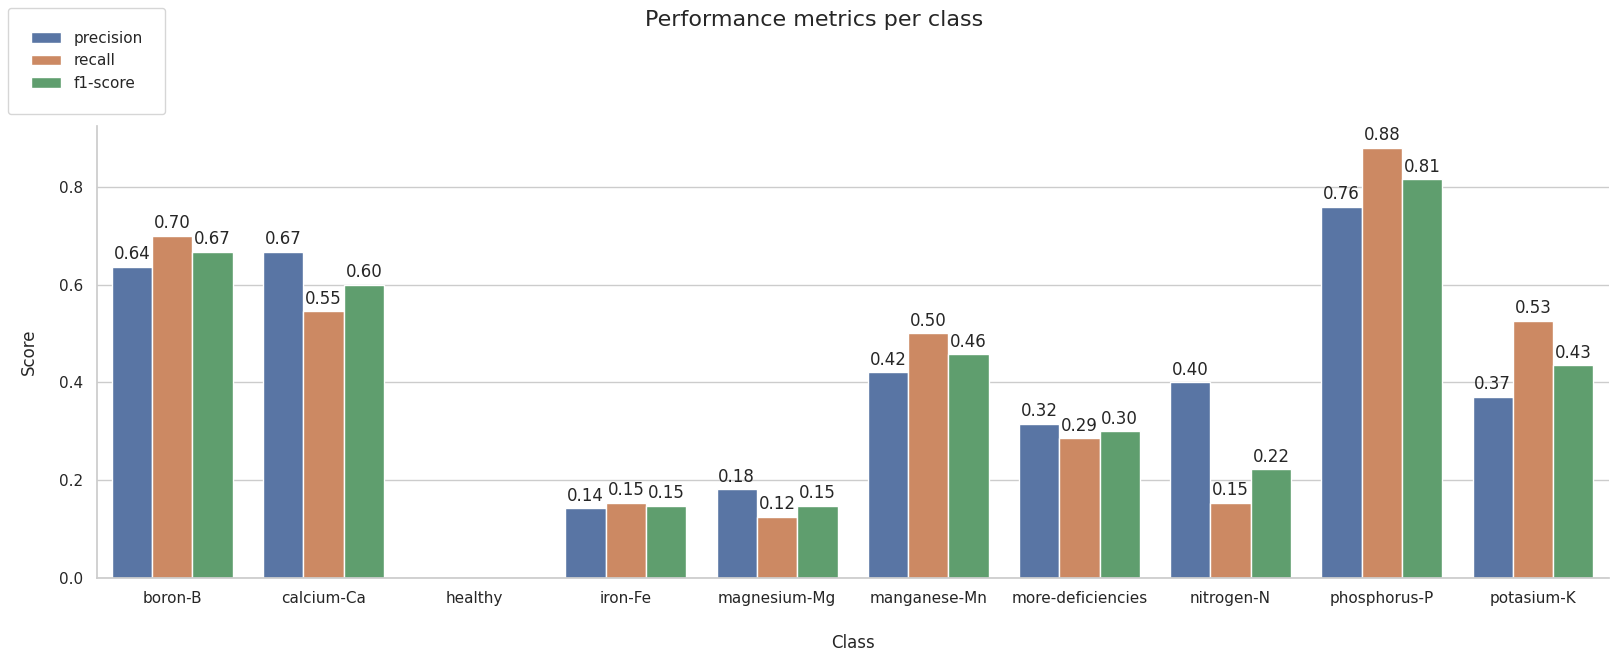

In [14]:
df_class_metrics = df_report[:-3]

df_melted = pd.melt(
    df_class_metrics,
    id_vars=['class'],
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)

g = sns.catplot(
    data=df_melted,
    kind="bar",
    x="class",
    y="Score",
    hue="Metric",
    aspect=2.5,
    height=6
)

g.figure.suptitle('Performance metrics per class', fontsize=16, y=1.1)

sns.move_legend(g, "upper left", borderpad=1.5, title=None, frameon=True)
sns.set_theme(style="whitegrid")

for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

plt.xlabel("Class", labelpad=20)
plt.ylabel("Score", labelpad=15)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/metrics_barchart_{MODEL_VERSION}.png"))
plt.show()

##### F1 Score vs. Class Proportion

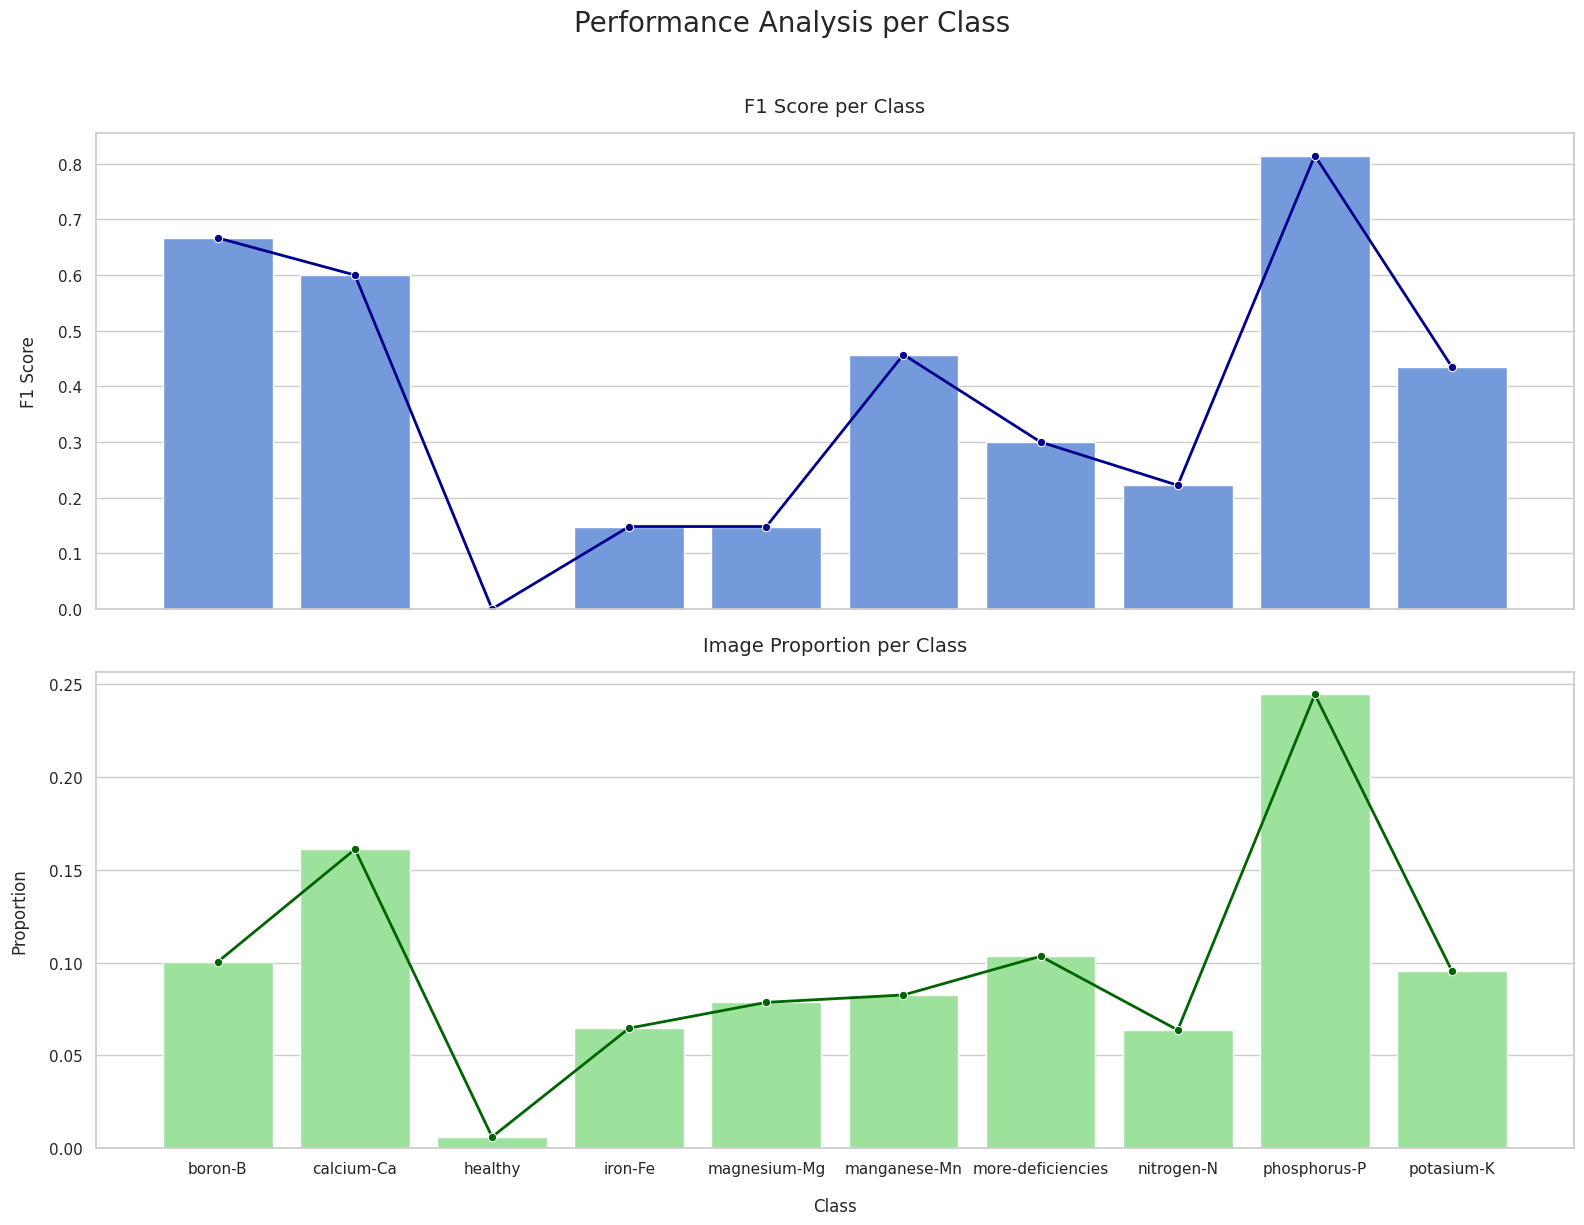

In [15]:
df_f1 = df_report.iloc[:-3, :][['f1-score']].copy()

total_images = len(class_labels)
image_counts = [class_labels.count(i) for i in range(len(classes))]
image_proportions = [count / total_images for count in image_counts]

df_plot_data = pd.DataFrame({
    'Class': classes,
    'F1 Score': df_f1['f1-score'].values,
    'Image Proportion': image_proportions
})

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Performance Analysis per Class', fontsize=20, y=1.02)

ax1 = axes[0]
sns.barplot(
    data=df_plot_data,
    x='Class',
    y='F1 Score',
    color='cornflowerblue',
    ax=ax1
)
sns.lineplot(
    data=df_plot_data,
    x='Class',
    y='F1 Score',
    color='darkblue',
    marker='o',
    linewidth=2,
    ax=ax1
)
ax1.set_title('F1 Score per Class', fontsize=14, pad=15)
ax1.set_ylabel('F1 Score', labelpad=15)
ax1.set_xlabel('')

ax2 = axes[1]
sns.barplot(
    data=df_plot_data,
    x='Class',
    y='Image Proportion',
    color='lightgreen',
    ax=ax2
)
sns.lineplot(
    data=df_plot_data,
    x='Class',
    y='Image Proportion',
    color='darkgreen',
    marker='o',
    linewidth=2,
    ax=ax2
)
ax2.set_title('Image Proportion per Class', fontsize=14, pad=15)
ax2.set_ylabel('Proportion', labelpad=15)
ax2.set_xlabel('Class', labelpad=15)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/f1_vs_class_proportion_{MODEL_VERSION}.png"))
plt.show()

#### Confusion Matrix

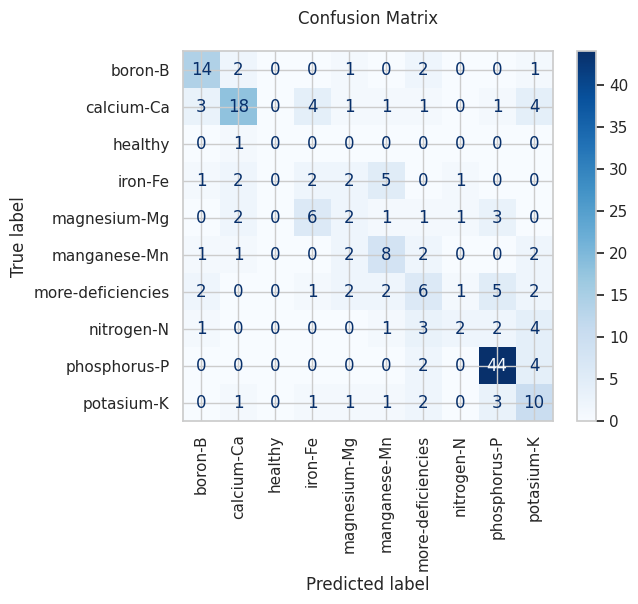

In [16]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix', pad=20)
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/confusion_matrix_{MODEL_VERSION}.png"))

#### ROC Curve

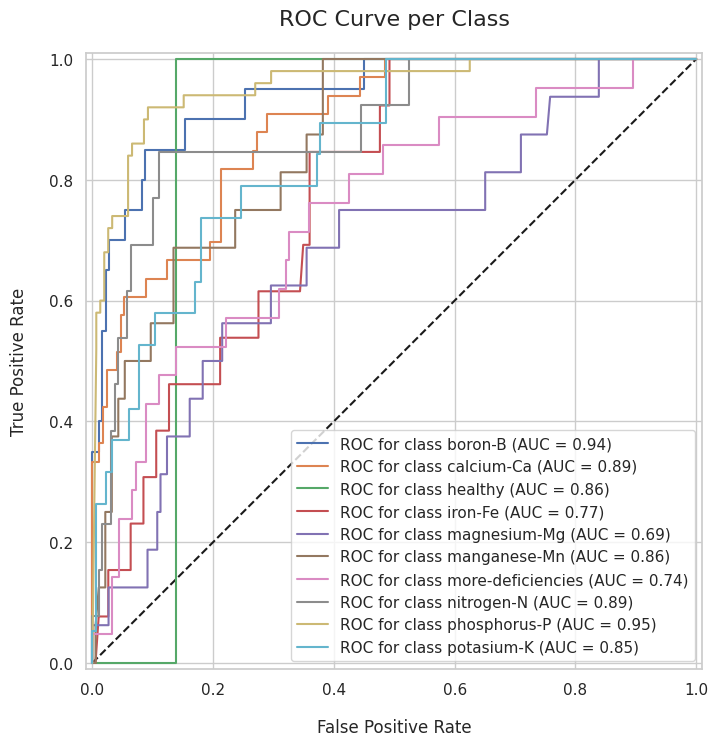

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the "no-skill" line for reference
ax.plot([0, 1], [0, 1], linestyle="--", color="k")

for i in range(len(classes)):
    RocCurveDisplay.from_predictions(
        y_true[:, i],
        all_probs[:, i],
        name=f"ROC for class {classes[i]}",
        ax=ax
    )

ax.set_xlabel("False Positive Rate", labelpad=15)
ax.set_ylabel("True Positive Rate", labelpad=15)
ax.set_title("ROC Curve per Class", fontsize=16, pad=20)
ax.legend(loc="lower right")
ax.grid(True)
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/roc_curve_display_{MODEL_VERSION}.png"))
plt.show()